# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias, Nidham Gazagnadou
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## <font color='red'>VERY IMPORTANT: if some of the following instructions is not followed, it will be penalized</font>

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 27th of november at 21:55**, using the **moodle platform**.
- Only **one submission by pair** of students
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "enrique"
ln1 = "gomez"
fn2 = "thihaiyen"
ln2 = "vu"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_gomez_enrique_and_vu_thihaiyen.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [5]:
print(numba.__version__) # Your version of Numba

0.45.1


In [6]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [7]:
%timeit go_fast(x)

1.27 µs ± 128 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [8]:
%timeit go_fast.py_func(x)

44.7 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [9]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    n = A.shape[0]
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    n = A.shape[0]
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    n = A.shape[0]
    return norm(A, ord=2) ** 2 / n + lbda

In [10]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    n = A.shape[0]
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    n = A.shape[0]
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [11]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [12]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [13]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/Users/QQINO/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


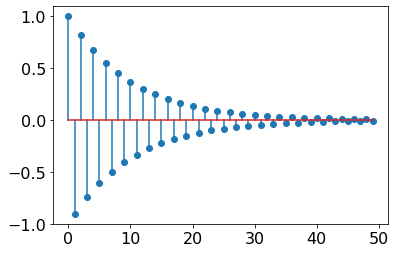

In [14]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [15]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.0347494362492936e-06

In [16]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.8915268593149777e-07

### Choice of the model

In [17]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [18]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.0628813416073271


### Get a very precise minimum to compute distances to minimum

In [19]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.5265445875415151
1.6814580676519783e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [20]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [21]:
# Number of full batch iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q1) Fill in the iteration of the GD solver in the cell below

In [22]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = x - step * grad(x,args[0],args[1],args[2])
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [23]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Q2) Fill in the iteration of the AGD solver in the cell below

In [24]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y,args[0],args[1],args[2])
        t_new = (1 + (1 + 4 * t**2 ) **.5)/2
        y = x_new + (t - 1)*(x_new - x)/(t_new)
        
        x = x_new
        t = t_new
        ### END TODO
    return x, x_list

In [25]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [26]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [27]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [28]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

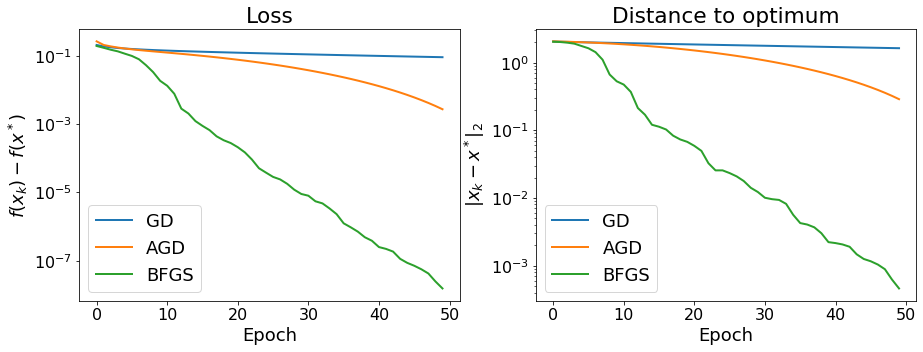

In [29]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

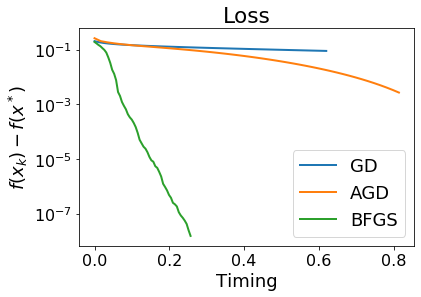

In [30]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Q3) Give some first conclusions about the batch solver studied here
- Q4) What do you observe about AGD? is it suprising ?

*ANSWERS*:
* **Q3)** We have the following observations:  
  * Both the GD and AGD methods converge very slowly to the minimiser as well as to the objective function's minimum, compared to the BFGS solver.
  * Considering the running time, the batch solvers are about 3 times slower than the BFGS solver. 
  * The AGD method performs much better than the GD method, but takes a little more time than GD method.
* **Q4)** We see that the ADG solver converges faster than the GD solver as expected, but it takes more time to execute, which is normal because it has to recalculate 3 values of $x_k,t_k,y_k$ at each iteration, instead of only one $x_k$ as the GD one.

However that difference is not substancial as the main source of computation is the computation of the gradient which is done inside the loop in both algorithms.






<a id='stoc'></a> 
## 4. Stochastic methods
*WARNING*: for stochastic methods ``n_iter`` corresponds to the number of epochs (number of full pass across the data)

In [31]:
n_iter = 50 # here corresponds to the number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Q5) Fill in the iteration of the SGD solver in the cell below

In [32]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - step * grad_i(i,x,args[0],args[1],args[2]) / (idx+1)**0.5
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [33]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q6) Fill in the iteration of the SAG solver in the cell below

In [34]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    n = args[0].shape[0]
    d = args[0].shape[1]
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        new_grad_i = grad_i(i,x,args[0],args[1],args[2])
        averaged_gradient = averaged_gradient + (new_grad_i - gradient_memory[i])/n
        gradient_memory[i] = new_grad_i
        
        x = x - step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [35]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Q7) Fill in the iteration of the SVRG solver in the cell below

In [36]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    n = args[0].shape[0]
    for idx in range(n_iter):
        
        ### TODO
        i = iis[idx]
        if idx % n == 0:
            x_old = x
            mu = grad(x_old,args[0],args[1],args[2])
            
        x = x - step*(grad_i(i,x,args[0],args[1],args[2])-grad_i(i,x_old,args[0],args[1],args[2])+mu)
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [37]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step, args=(A, b, lbda))

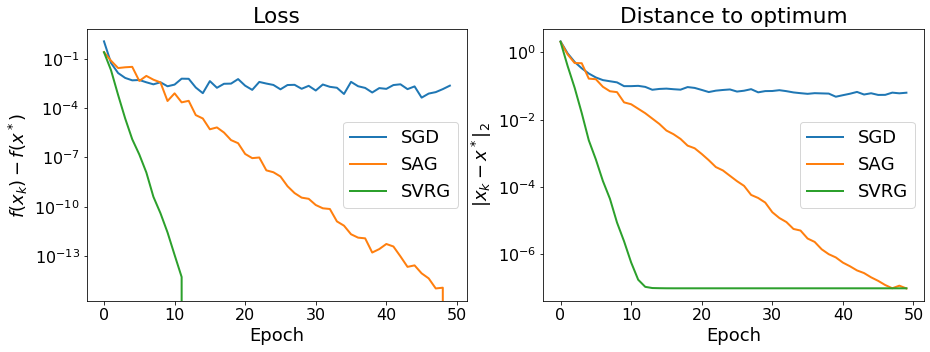

In [38]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

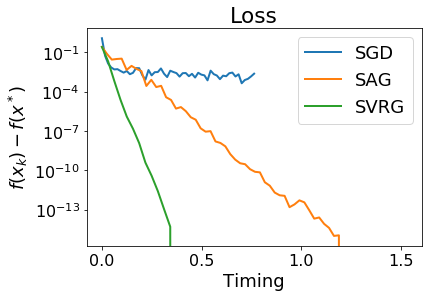

In [39]:
plot_time(monitors, solvers)

In [40]:
for monit, solv in zip(monitors, solvers):
    print("Running time of",solv,":",monit.total_time,"s")

Running time of SGD : 0.7635462284088135 s
Running time of SAG : 1.2136402130126953 s
Running time of SVRG : 1.5268950462341309 s


### First conclusions

*QUESTIONS*:

- Q8) Compare the converge (on the different plots) of the stochastic methods you implemented

*ANSWERS:*
* **Q8)** We compare the following criteria:
  * ***Distance to the optimal loss:*** SGD method converges very slowly to the optimum after several epochs, with a difference to the minimum loss of $10^{-2}$  after $50$ epochs; while SAG method gives a more consistent convergence with an error of $10^{-13}$ after $50$ epochs; SVRG method gives the best performance for obtaining an error of $10^{-13}$ after about $10$ epochs.
  * ***Distance to the minimiser:*** We obtain similar behaviors to the previous case. SDG doesn't improve much after epoch $10$, while SAG converges consistently to the optimum, and SVRG converges quickly to the optimum after about $13$ epochs.
  * ***Running time:*** The 3 methods takes comparably short time to execute all 50 epochs, with $0.62$s, $0.87s$ and $1.05s$ respectively for SGD, SAG and SVRG. However, looking at the time plot, we see that SGD is better than SAG at the first time, then it starts to oscillate and performs worse than SAG, while the SVRG method nearly attains the optimum around $0.3s$. Note that to implement efficiently the SAG, we use a trick to update $G_t$:$$G_{t} = G_{t-1} - \dfrac{1}{n}g_i^t + \dfrac{1}{n}\nabla f_{i}(x_t), $$
  where $i=i_t$, so that it only takes $O(1)$ to compute $G_t$ instead of $O(n)$.
  * ***Stability:*** We see that both SDG and SAG methods give unstable loss curves, with SAG a little more stable, while the SVRG method gives a very stable curve.

<a id='comp'></a> 
## 5. Numerical comparison

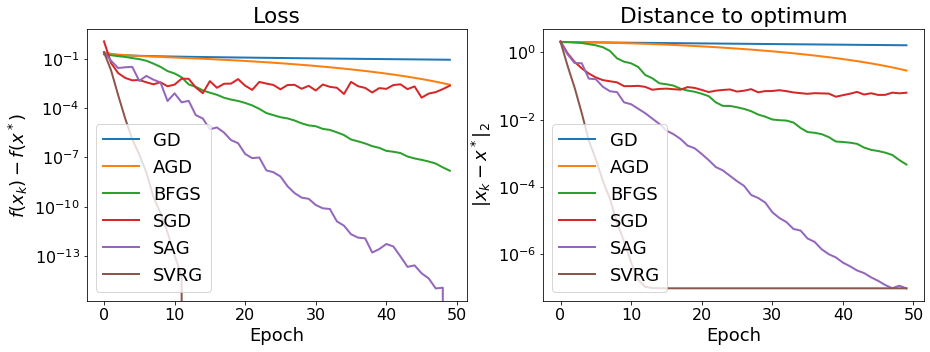

In [41]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

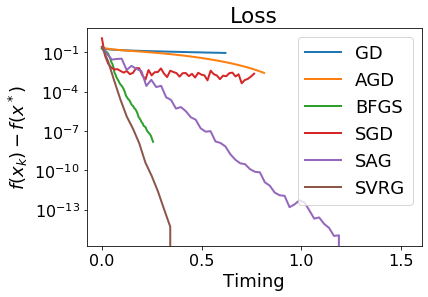

In [42]:
plot_time(monitors, solvers)

In [43]:
for monit, solv in zip(monitors, solvers):
    print("Running time of",solv,":",monit.total_time,"s")

Running time of GD : 0.6195237636566162 s
Running time of AGD : 0.8137919902801514 s
Running time of BFGS : 0.2567269802093506 s
Running time of SGD : 0.7635462284088135 s
Running time of SAG : 1.2136402130126953 s
Running time of SVRG : 1.5268950462341309 s


<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:

For all the following questions, try to show only **FEW INFORMATIVE FIGURES** that highlight your conclusions.
- Q9) Compare the deterministic and the stochastic gradient methods. Comment your results.
- Q10) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- Q11) Look carefuly on how the data are generated in functions  ``simu_linreg`` and ``simu_logreg``. Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- Q12) Change the number of data points $n$ and the number of data samples $d$ and compare your results. Comment.
- Q13) Conclude on the performance on the implemented methods. Are their "regimes" for which some methods are faster than others?
- Q14) Are there different behaviours between the deterministic methods? What about the stochastic ones?
- Q15) Compare the memory, the number of hyper-parameters to tune and the ease of implementation of each algorithm. According to this, in which configuration do you think a user should use deterministic method rather than a stochastic one, and vice-versa?

In [44]:
def plot_epochs_and_time(monitors, solvers,title=""):
    fig = plt.figure(figsize=(25, 5))
    st = fig.suptitle(title,y=1.1,fontsize="x-large")
    
    ax1 = fig.add_subplot(1, 3, 1)
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("$f(x_k) - f(x^*)$")
    ax1.legend(solvers)

    ax2 = fig.add_subplot(1, 3, 2)
    for monit in monitors:
        ax2.semilogy(monit.err, lw=2)
        ax2.set_title("Distance to optimum")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("$\|x_k - x^*\|_2$")
    ax2.legend(solvers)
    
    ax3 = fig.add_subplot(1, 3, 3)
    for monit in monitors:
        objs = monit.obj
        ax3.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        ax3.set_title("Loss")
        ax3.set_xlabel("Timing")
        ax3.set_ylabel("$f(x_k) - f(x^*)$")
    ax3.legend(solvers)

In [45]:
def simulation(model,plot,d_=50,n_=10000,lbda_exp=0.5,corr_=0.9,std_=1.,n_iter_=50,title=""):
  d = d_
  n = n_
  idx = np.arange(d)

  # Ground truth coefficients of the model
  x_model_truth = (-1)**idx * np.exp(-idx / 10.)

  if model == 'linreg':
    A, b = simu_linreg(x_model_truth, n, std=std_, corr=corr_)
    loss = loss_linreg
    grad = grad_linreg
    grad_i = grad_i_linreg
    lipschitz_constant = lipschitz_linreg
  elif model == 'logreg':
    A, b = simu_logreg(x_model_truth, n, std=std_, corr=corr_)
    loss = loss_logreg
    grad = grad_logreg
    grad_i = grad_i_logreg
    lipschitz_constant = lipschitz_logreg
  
  lbda = 1. / n ** lbda_exp
  x_init = np.zeros(d)
  x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
  n_iter = n_iter_
  
  iis = np.random.randint(0, n, n * n_iter)
  
  ## Gradient Descent
  step = 1. / lipschitz_constant(A, b, lbda)
  x_init = np.zeros(d)
  monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
  monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

  ## Accelerated Gradient Descent
  step = 1. / lipschitz_constant(A, b, lbda)
  x_init = np.zeros(d)
  monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
  monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

  ## BGFS
  x_init = np.zeros(d)
  monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
  monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

  ## Stochastic Gradient Descent
  step0 = 1e-1
  x_init = np.zeros(d)
  monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
  monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, store_every= n, args=(A, b, lbda))

  ## Stochastic Average Gradient
  max_squared_sum = np.max(np.sum(A ** 2, axis=1))
  step = 1.0 / (max_squared_sum + lbda)
  x_init = np.zeros(d)
  monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
  monitor_sag.run(x_init, iis, grad_i, n_iter * n, step,store_every= n, args=(A, b, lbda))

  ## Stochastic Varience Reduced Gradient
  x_init = np.zeros(d)
  monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
  monitor_svrg.run(x_init, iis, grad, grad_i, n_iter * n, step,store_every= n, args=(A, b, lbda))

  monitors = [monitor_gd, monitor_agd, monitor_bfgs,
              monitor_sgd, monitor_sag, monitor_svrg]

  solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]
  
  if plot == 'epoch':
    plot_epochs(monitors, solvers)
  elif plot == 'time':
    plot_time(monitors, solvers)
  elif plot == 'epoch_and_time':
    plot_epochs_and_time(monitors, solvers,title)
  
  

*ANSWERS:*
### **Question 9**

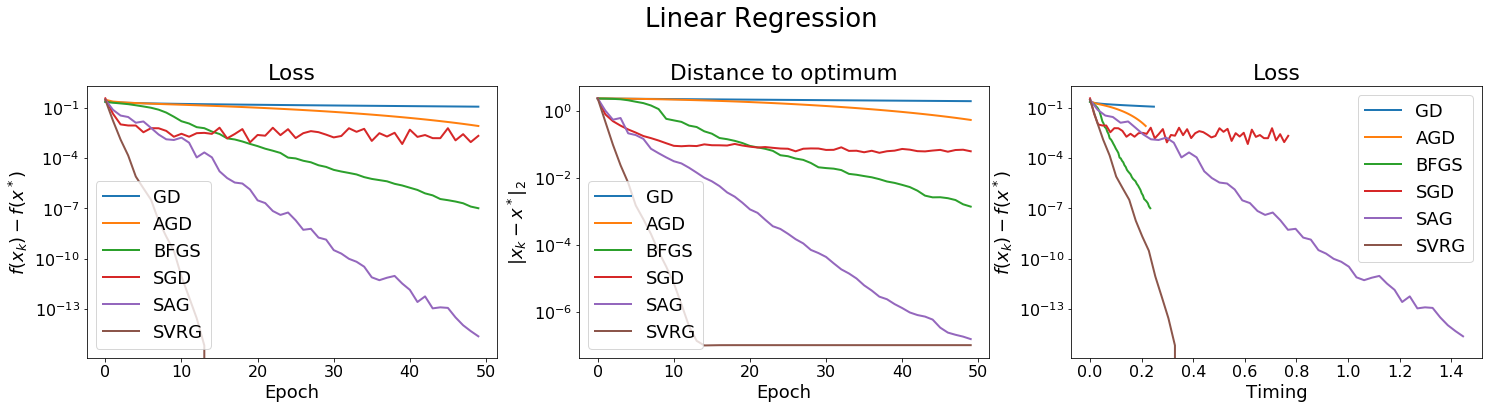

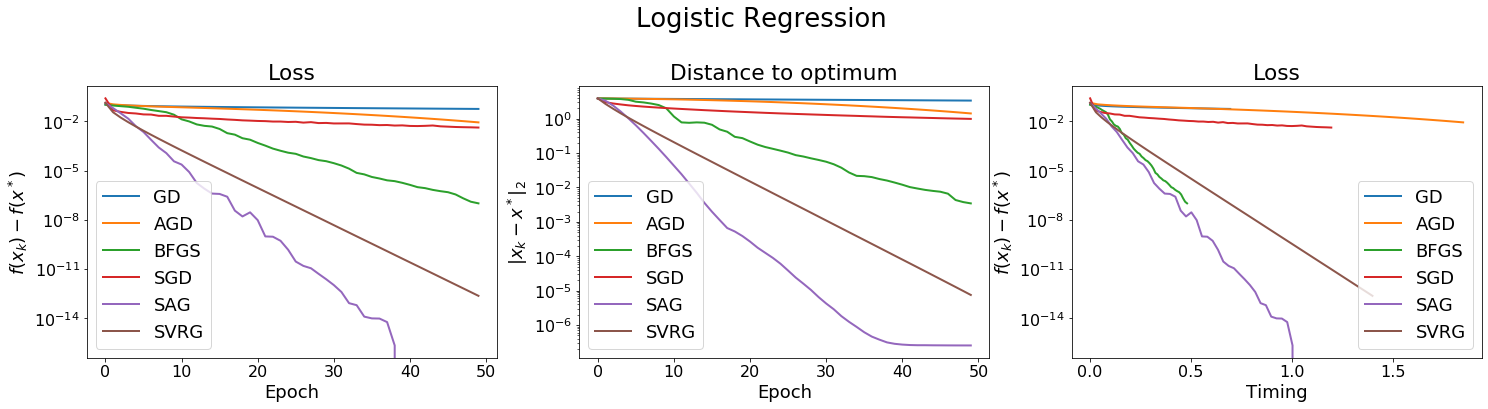

In [46]:
simulation(model='linreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=1,corr_=0.9,std_=1.,n_iter_=50,title="Linear Regression")
simulation(model='logreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=1,corr_=0.9,std_=1.,n_iter_=50,title="Logistic Regression")

#### **Comments**
  * **Stochastic gradient methods** give generally better results than deterministic ones, specially for SAG and SRVG methods. This is because stochastic methods update the gradient online at every step, hence converge faster. In this particular case, we see that SVRG performs better than SAG for the Linear Regression and SAG does better than SVRG for Logistic Regression. 
  * **Deterministic gradient methods** are indeed more stable than stochastic methods. However, considering the stochastic methods, the SRVG method is more stable than the two other ones. In addition, stochastic methods are more stable for Logistic Regression than for Linear Regression. It is important to mention that BFGS gives better results than SGD in the long run, even if the later is quicker, it does not improves much its accuracy after attaining a mark.



### **Question 10**

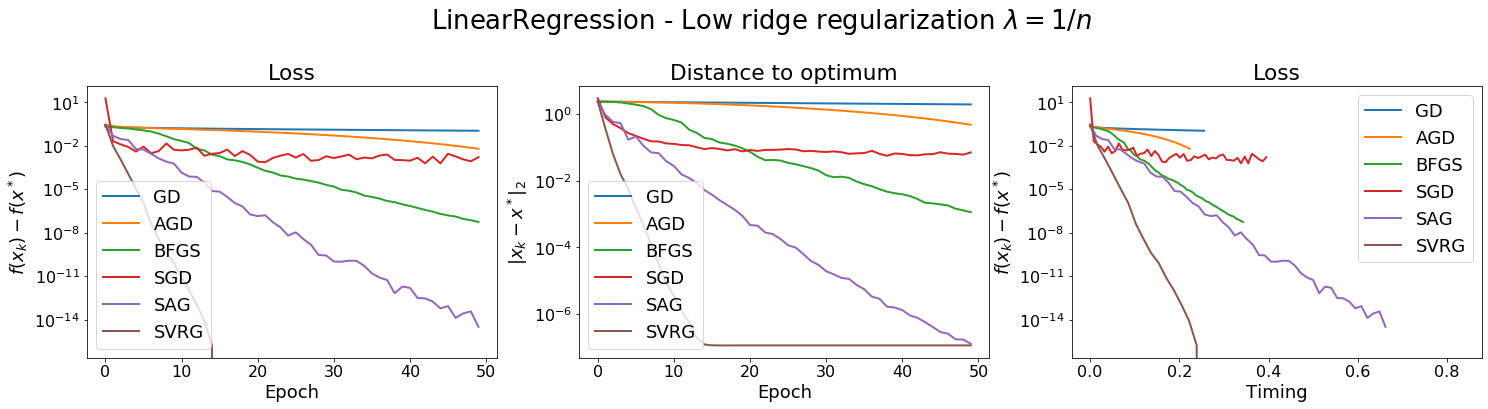

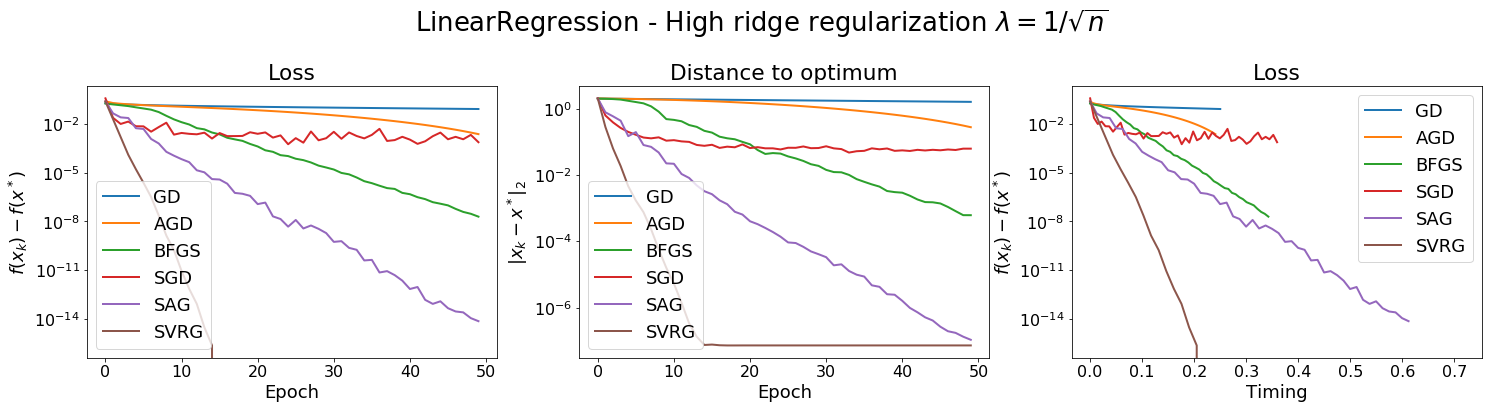

In [47]:
simulation(model='linreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=1,corr_=0.9,std_=1.,n_iter_=50,title="LinearRegression - Low ridge regularization $\lambda = 1 / n$")
simulation(model='linreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=0.5,corr_=0.9,std_=1.,n_iter_=50,title="LinearRegression - High ridge regularization $\lambda = 1 / \sqrt{n}$")

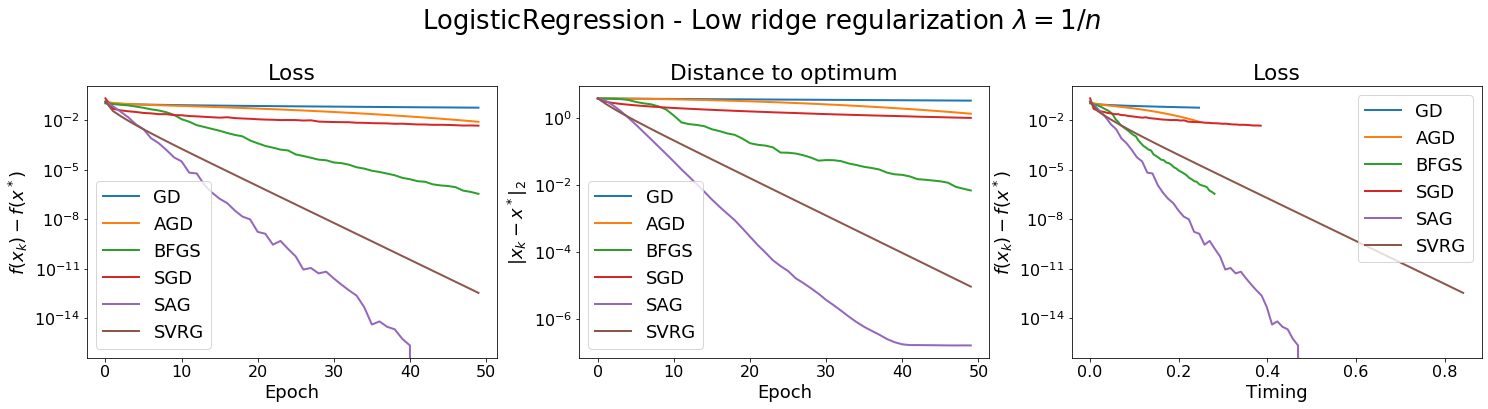

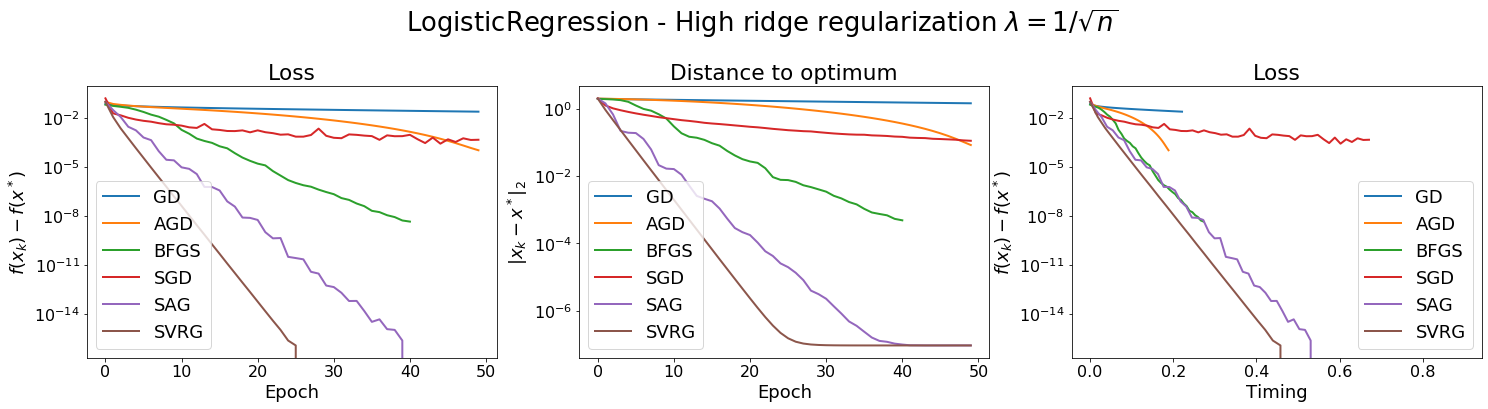

In [48]:
simulation(model='logreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=1,corr_=0.9,std_=1.,n_iter_=50,title="LogisticRegression - Low ridge regularization $\lambda = 1 / n$")
simulation(model='logreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=0.5,corr_=0.9,std_=1.,n_iter_=50,title="LogisticRegression - High ridge regularization $\lambda = 1 / \sqrt{n}$")

#### **Comments**
* **Low ridge regularization** is generally slightly better than the high one in Linear Regression. It gives slightly quicker descents.
* **High ridge regularization**, on the other hand, performs way better than the low ridge one for Logistic Regression, especially for SVRG and AGD methods, they both converge. We can verify that the descent is way quicker as well as the timing. However, the stochastic methods are slightly less stable using high regularization, specially the SGD. 

### **Question 11**

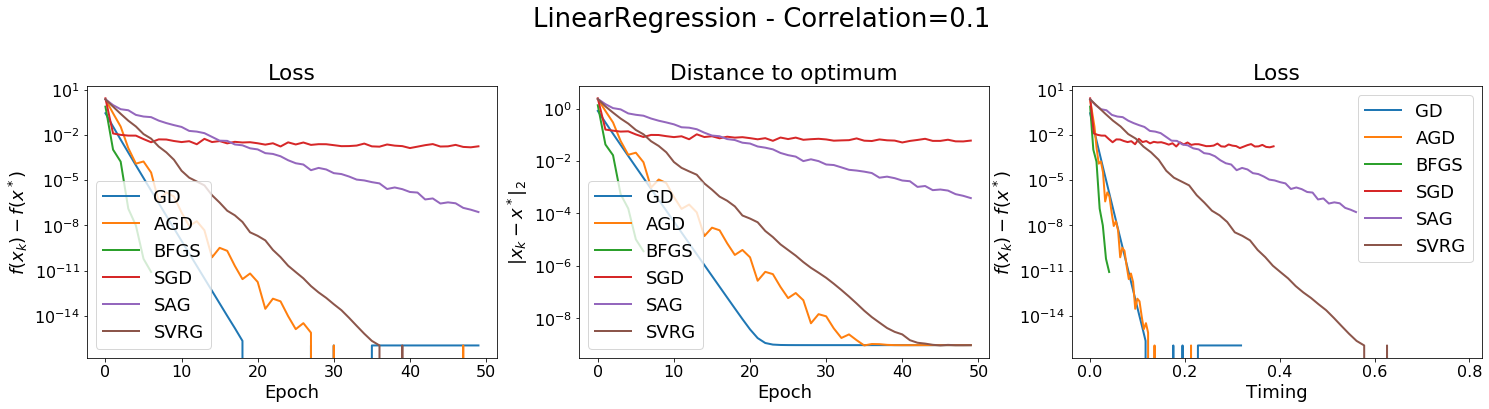

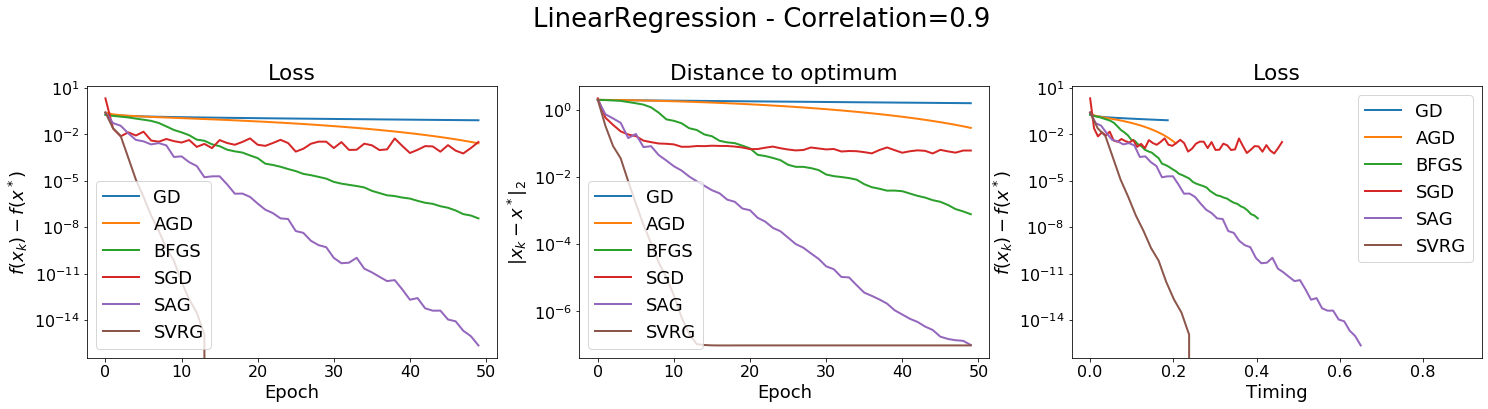

In [49]:
for c in [0.1,0.9]:
  simulation(model='linreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=0.5,corr_=c,std_=1.,n_iter_=50, title="LinearRegression - Correlation={}".format(c))

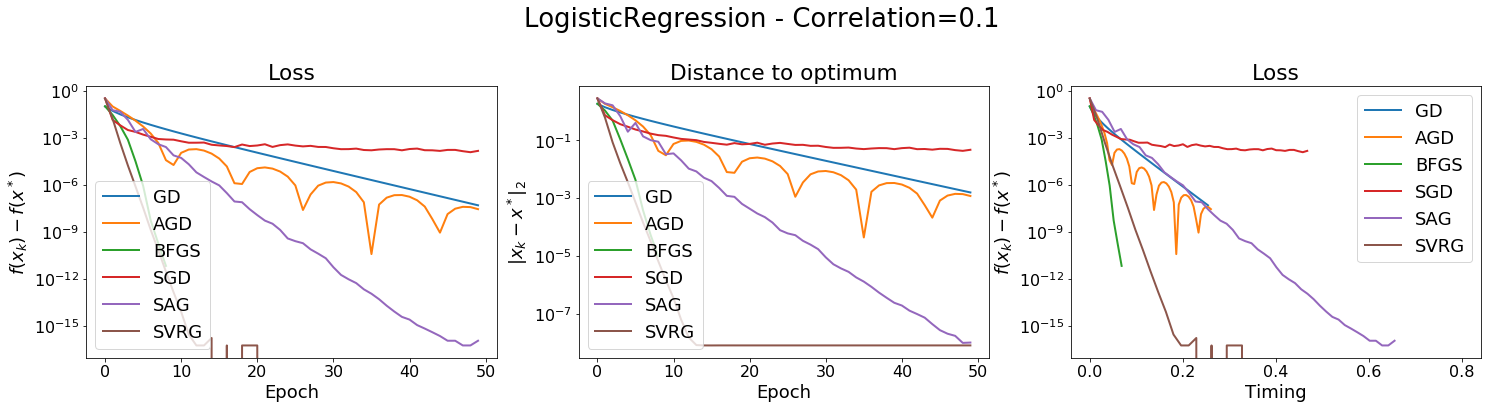

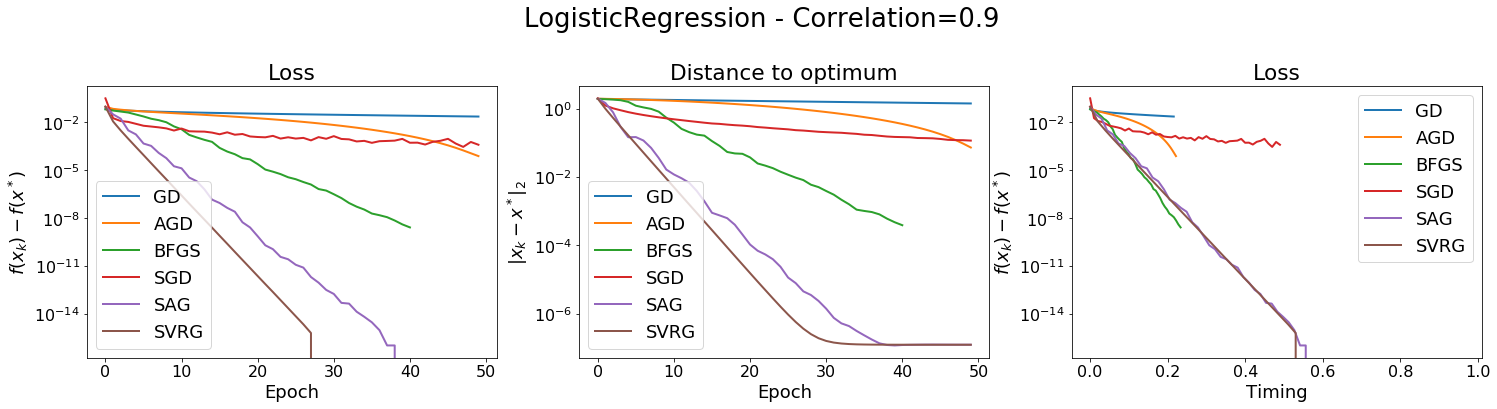

In [50]:
for c in [0.1,0.9]:
  simulation(model='logreg',plot='epoch_and_time',d_=50,n_=10000,lbda_exp=0.5,corr_=c,std_=1.,n_iter_=50, title="LogisticRegression - Correlation={}".format(c))

#### **Comments**
* **Deterministic methods** are highly affected by the level of correlation, performing very well for uncorrelated data but much worse for correlated data. Surprisingly, AGD is even slower than GD for uncorrelated data in the Linear Regression case. AGD gets really unstable with uncorrelated data. 
* **Stochastic methods**, in general, peforms poorly for uncorrelated data than for correlated data, in tems of speed of convergence and accuracy. However, SVRG method seems to perform a less well with correlated data in the Logistic Regression case. Otherwise, it gives good results. SGD seems to be resistant to the variation of the correlation.

### **Question 12**



In [ ]:
for n in [1000,100000]:
    simulation(model='logreg',plot='epoch_and_time',d_=50,n_=n,lbda_exp=0.5,corr_=0.9,std_=1.,n_iter_=50,title="n={}".format(n))

In [ ]:
for d in [10,150]:
    simulation(model='linreg',plot='epoch_and_time',d_=d,n_=10000,lbda_exp=0.5,corr_=0.9,std_=1.,n_iter_=50,title="d={}".format(d))

#### **Comments**
* **Comparing different values of n**: Low values of n benefit deterministic methods, especially for AGD and BFGS. The later is even better than SVRG with little data ! On other hand, as more data is given, stochastic methods perform considerably well . However, it takes more time to optimize as we increase the dataset. GD is the quickest as expected but gives the worst results. The convergence of stochastic algorithms gets better with more data. SG does not improve much though, only its convergence gets quicker.
* **Comparing different values of d**: We observe that as d increases, all the methods deteriorate. We also note that when d is too large compared to the number of data points, SGD fails to optimize and diverge for the several epochs at the beginning, then it starts to converge to the optimum. This is known as the curse of dimensionality. SGD is the more sensible to very high dimensions, it diverges to quickly.


### **Question 13**
Comments on the performance of the implemented methods:
* **GD**: Generally the worst method among all, with very slow convergence. However, this method could be very effective if the data are uncorrelated. It is in general the quickest 
* **AGD**: Better than GD method. Generally better than SGD for uncorrelated data or when the size of dataset is small, but still worse than SAG and SVRG.
* **SGD**: Better than deterministic methods if data is highly correlated. Usually worse than SAG and SVRG, except at first few epochs when SGD decreases quickly. Can diverge at the start if the dimension of the data is too large compared to the number of dataset. It converges rather quickly in general
* **SAG**: Very good performance compared to other methods, converge consistently, but takes time. Always outperform SGD's accuracy after an amount of time. It works very well for Logistic Regression.
* **SVRG**: Generally the best method among all in term of accuracy and speed of convergence. Usually better than SAG method, except for the Logistic Regression problem using Low ridge regularization or using a small dataset. Could be less well than deterministic methods in the case Linear Regression with very low correlated data.

### **Question 14**
Comments on the behavior of the implemented methods:
* **GD**: Stable and quick in most cases, but decrease slowly.
* **AGD**: Often an oscillating decrease (jump down) for low correlated data. 
* **SGD**: Highly unstable, specially for Linear Regression problem. Often decrease very fast to its convergence value at the start but then it starts to oscillate.
* **SAG**: A bit more stable than SGD. It is consistent in terms of convergence but is slow.
* **SVRG**: The most stable stochastic method. Its convergence is very fast in most of the cases and is the quickest. 

### **Question 15**
We summarize the methods as follows:

| Methods | Memory | Number of hyper-parameters | Ease of implementation |
| --- | --- | --- | --- |
| GD | O(d) | 1* | Very Easy |
| AGD | O(d) | 1* | Easy | 
| SGD | O(d) | 1* | Easy but could be optimized |
| SAG | O(nd) | 1* | Not easy |
| SVRG | O(d) | 1* | Not easy |

\*: 1 Parameter which is the step size. There are 2 hyper-parameteres if we count the ridge regularization which has to be tuned for each method.


Deterministic methods have in general less parameters. So they are easier to tune. However, stochastic algorithms uses only a fraction of the data set, so they require less memory stored at a given time. That is why they are in general more vulnerable to little data and work better and faster for big data sets. Deterministic algortithms should be used for small data sets because they take less time in general.